In [65]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import seaborn as sns




Есть продажи некоторых продуктов по дням отдельно в каждый канал продаж (Shipments_by_PO.csv) на период с января 17 по июнь 18. Также указано, с какой скидкой был продан продукт. Продажи могут быть не во все дни.
  * Есть привязка каждого канала продаж к т.н. направлению продаж – оптовая или розничная торговля (Mapping.csv)
  * Есть прогноз, с какой скидкой будут продаваться продукты в июле-августе 18 (Forecast_of_discounts.xlsx). Если продукта/направления нет в файле, значит скидка – 0%
  * Нужно построить прогноз продаж на июль-сентябрь 18 с помощью простейшего алгоритма – линейной регрессии.
  * Регрессию нужно построить по каждой комбинации продукт-направление отдельно, учитывая номер месяца, года и размер скидки. Номер месяца нужно преобразовать с помощью One-Hot Encoding.
  * Прогноз нужен на уровне месяца, продукта и направления продаж, соответственно, все данные нужно сначала преобразовать на данный уровень с помощью Pandas.

In [27]:
data_shipments = pd.read_csv('C:/Users/Peter/Documents/GitHub/PeterOstr/test_run/Shipments_by_PO.csv')
data_mapping = pd.read_csv('C:/Users/Peter/Documents/GitHub/PeterOstr/test_run/Mapping.csv')
data_forecast = pd.read_excel('C:/Users/Peter/Documents/GitHub/PeterOstr/test_run/Forecast_of_discounts.xlsx')


In [28]:
a = data_forecast['Код товара'].value_counts()
len(a)

573

In [29]:
#проверим на наличие пропусков
{key:data_forecast[key].isna().sum() for key in data_forecast.columns}


{'Код товара': 0, 'Направление продаж': 0, 'Month': 0, 'Year': 0, 'Скидка': 0}

In [30]:
#проверим на наличие пропусков

{key:data_shipments[key].isna().sum() for key in data_shipments.columns}


{'Код товара': 0,
 'Канал': 0,
 'Дата накладной': 0,
 'Продажи, шт': 0,
 'скидка': 0}

In [31]:
#добавил столбец направление продаж

data = data_shipments.copy()
data = pd.merge(data, data_mapping, on='Канал', how='left')
data

,Код товара,Канал,Дата накладной,"Продажи, шт",скидка,Направление продаж
0,299,Канал 1,06.01.2017,32,19,Розничная торговля
1,299,Канал 1,09.01.2017,59,19,Розничная торговля
2,299,Канал 1,10.01.2017,22,2,Розничная торговля
3,299,Канал 1,11.01.2017,35,10,Розничная торговля
4,299,Канал 1,12.01.2017,55,4,Розничная торговля
...,...,...,...,...,...,...
808089,311,Канал 13,25.05.2018,63,2,Оптовая торговля
808090,311,Канал 13,05.06.2018,48,6,Оптовая торговля
808091,311,Канал 13,08.06.2018,68,6,Оптовая торговля
808092,311,Канал 13,20.06.2018,51,8,Оптовая торговля


In [32]:
# заменим направлени продаж для удобства цифрами

data["Направление продаж"].replace({"Розничная торговля": "01",
                      "Оптовая торговля": "02"}, inplace=True)

In [33]:
# разобьем дату на отдельные элементы

data[["day", "month", "year"]] = data["Дата накладной"].str.split(".", expand = True)

data.drop(["day",'Дата накладной'], axis=1, inplace=True)


In [34]:
# создадим новую кодировку позиции - код товара+направление продаж, чтобы сагрегировать потом продажи
# в рамках месяца

data['code_sales'] = data['Код товара'].astype(str) + data['Направление продаж']

data

,Код товара,Канал,"Продажи, шт",скидка,Направление продаж,month,year,code_sales
0,299,Канал 1,32,19,01,01,2017,29901
1,299,Канал 1,59,19,01,01,2017,29901
2,299,Канал 1,22,2,01,01,2017,29901
3,299,Канал 1,35,10,01,01,2017,29901
4,299,Канал 1,55,4,01,01,2017,29901
...,...,...,...,...,...,...,...,...
808089,311,Канал 13,63,2,02,05,2018,31102
808090,311,Канал 13,48,6,02,06,2018,31102
808091,311,Канал 13,68,6,02,06,2018,31102
808092,311,Канал 13,51,8,02,06,2018,31102


In [35]:
# удалим лишнее

data.drop(["Код товара",'Канал','Направление продаж'], axis=1, inplace=True)
data

,"Продажи, шт",скидка,month,year,code_sales
0,32,19,01,2017,29901
1,59,19,01,2017,29901
2,22,2,01,2017,29901
3,35,10,01,2017,29901
4,55,4,01,2017,29901
...,...,...,...,...,...
808089,63,2,05,2018,31102
808090,48,6,06,2018,31102
808091,68,6,06,2018,31102
808092,51,8,06,2018,31102


In [36]:
# агрегируем по продажам в рамках месяца

data_new = data.groupby(['code_sales','year','month','скидка']).sum()
data_new = data_new.reset_index()
data_new

,code_sales,year,month,скидка,"Продажи, шт"
0,10001,2017,01,0,117
1,10001,2017,01,4,54
2,10001,2017,01,6,35
3,10001,2017,01,11,123
4,10001,2017,01,12,28
...,...,...,...,...,...
313863,9902,2018,06,1,94
313864,9902,2018,06,2,113
313865,9902,2018,06,3,95
313866,9902,2018,06,5,53


In [37]:
data_new['code_sales'] = data_new['code_sales'].astype(int)

In [39]:
# попробуем в лоб применить линейную регрессию к датасету, бьем на признаки и целевую переменную
y = data_new['Продажи, шт']
X = data_new.drop(['Продажи, шт'], axis=1)

# также выделим часть данных для проверки качества модели 
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=0.3,shuffle=True)

model_all = LinearRegression()
model_all.fit(X_train, y_train)

In [44]:
print ('r2_score:', r2_score(y_holdout, model_all.predict(X_holdout)))
print ('mean_squared_error:',mean_squared_error(y_holdout, model_all.predict(X_holdout)))
print ('mean_absolute_percentage_error:',mean_absolute_percentage_error(y_holdout, model_all.predict(X_holdout)))

r2_score: 0.012181419842590246
mean_squared_error: 7117.54146078058
mean_absolute_percentage_error: 0.8963282005210962


Видим по метрикам что получившаяся лин модель вообще не описывает зависимости:
   * R2 метрика - лучший результат может быть 1, в нашем случае 0.012, это значит что модель не предсказывает вне зависимости от введенных данных
   * mean_squared_error - среднеквадратичная ошибка, здесь легко понять насколько она большая сравнив значение продаж за месяц одного товара - порядок десятки-сотня и данное значение 7117.54
   * mean_absolute_percentage_error - чем ниже тем лучше, у нас оно имеет очень большое значение, близкое к 1 (применять по идее эту метрику можем, потому что нулевых продаж нет за месяц. Если бы были, то эта метрика не подходит)
  
**Тогда может, попробовать построить лин регрессиую по одному наименованию, и тогда получим сносный результат?**

In [49]:
# возьмем из датасета данныe XY по 1 наименованию 
XY = data_new[data_new['code_sales'] == 10001]

y = XY['Продажи, шт']
X = XY.drop(['Продажи, шт'], axis=1)

# также выделим часть данных для проверки качества модели 
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=0.3,shuffle=True)

model_one = LinearRegression()
model_one.fit(X_train, y_train)

LinearRegression()

In [50]:
print ('r2_score:', r2_score(y_holdout, model_one.predict(X_holdout)))
print ('mean_squared_error:',mean_squared_error(y_holdout, model_one.predict(X_holdout)))
print ('mean_absolute_percentage_error:',mean_absolute_percentage_error(y_holdout, model_one.predict(X_holdout)))

r2_score: 0.01825203514409346
mean_squared_error: 1983.9592388542783
mean_absolute_percentage_error: 0.7059941694149412


Видим, что результаты немного лучше, но все равно у нас так и не получилось построить модель

In [73]:
XY['скидка']

0       0
1       4
2       6
3      11
4      12
       ..
207    12
208    13
209    16
210    17
211    18
Name: скидка, Length: 212, dtype: int64

In [63]:
np.asarray(XY)[0]

array([10001, '2017', '01', 0, 117], dtype=object)

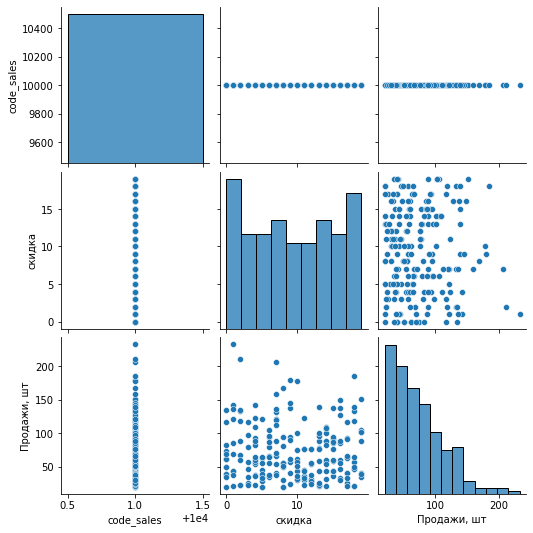

In [66]:
sns.pairplot(XY)


По графикам также не видно линейной зависимости

In [77]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
# print(smf.ols("'Продажи, шт' ~ 'скидка'", data = XY).fit().summary())
print(smf.ols("XY['Продажи, шт'] ~ XY['скидка']", data = XY).fit().summary())

                            OLS Regression Results                            
Dep. Variable:      XY['Продажи, шт']   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.004
Method:                 Least Squares   F-statistic:                    0.1504
Date:                Sun, 13 Feb 2022   Prob (F-statistic):              0.699
Time:                        20:04:03   Log-Likelihood:                -1092.5
No. Observations:                 212   AIC:                             2189.
Df Residuals:                     210   BIC:                             2196.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       74.2107      5.510     13.469   

На всякий случай еще запустим анализ парной регрессии из статистического пакета и посмотрим:
   * самый главный показатель  R-squared - около нуля (это то количество данных которая наша модель объясняет, ничего не объясняет, значит наша модель не работает)
   * ну и помимо прочего коэф при скидке  -0.1943 - гораздо меньше стандартной ошибки,=>, коэффициент не значим

In [82]:
# так как было сказано месяц представить в виде one-hot encoding сделаем это, хотя это лишено смысла в контексте задачи
data_new = pd.get_dummies(data_new, columns=['month'], drop_first=False)
data_new

,code_sales,year,скидка,"Продажи, шт",month_01,month_02,month_03,month_04,month_05,month_06,month_07,month_08,month_09,month_10,month_11,month_12
0,10001,2017,0,117,1,0,0,0,0,0,0,0,0,0,0,0
1,10001,2017,4,54,1,0,0,0,0,0,0,0,0,0,0,0
2,10001,2017,6,35,1,0,0,0,0,0,0,0,0,0,0,0
3,10001,2017,11,123,1,0,0,0,0,0,0,0,0,0,0,0
4,10001,2017,12,28,1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
313863,9902,2018,1,94,0,0,0,0,0,1,0,0,0,0,0,0
313864,9902,2018,2,113,0,0,0,0,0,1,0,0,0,0,0,0
313865,9902,2018,3,95,0,0,0,0,0,1,0,0,0,0,0,0
313866,9902,2018,5,53,0,0,0,0,0,1,0,0,0,0,0,0


**Вывод:**

Зависимости целевой переменной - продаж от параметров (скидка, месяц, год) не имеют линейной зависимости, соответственно не имеет смысла пытаться предсказать продажи в 18 году при помощи лин регрессии. Как вариант, возможно здесь стоит применить модели временных рядов (ARIMA, SARIMA)